In [1]:
from datetime import datetime

from concurrent.futures import ThreadPoolExecutor
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import urllib.parse

from scrap_amazon_price import scrap_amazon_price

In [6]:
def running_futures (dataframe):
    lego_ids = dataframe.index.to_list()
    with ThreadPoolExecutor (max_workers= 7) as pool:
        results = pool.map(scrap_amazon_price, lego_ids)
    amazon_prices = [r for r in results]
    return amazon_prices
            

def text_preprocessing_remove_LEGO (theme:str)->str:
    theme= str(theme).replace('LEGO® ','').replace('™','').replace('®','')
    return theme


def assessing_price_increase (price, amazon_price, year):
    current_year = int(datetime.today().strftime('%Y'))
    try:
        increase_per_year = float(amazon_price) - price / (current_year - year)
        percentage_per_year = (increase_per_year / float(price))*100
    except ZeroDivisionError:
        percentage_per_year = 0
    return percentage_per_year

In [7]:
df= pd.read_csv ('data\lego_population.csv',
                index_col = 'item_number',
                engine='python'
                ).fillna(0
                        ).drop (['ages','pages', 'weight', 'packaging','size', 'pieces', 'minifigures', 'unique_pieces'], axis=1
                               ).assign(theme = lambda x: x['theme'].map(text_preprocessing_remove_LEGO))
df =df.drop(df[df.price == 0].index)

df

,set_name,theme,price,amazon_price,year
item_number,,,,,
41916,Extra Dots - Series 2,DOTS,3.99,3.44,2020
41908,Extra Dots - Series 1,DOTS,3.99,3.99,2020
11006,Creative Blue Bricks,Classic,4.99,4.93,2020
11007,Creative Green Bricks,Classic,4.99,4.93,2020
41901,Funky Animals Bracelet,DOTS,4.99,4.99,2020
...,...,...,...,...,...
45678,SPIKE Prime Set,Education,329.95,0.00,2020
71367,Mario's House & Yoshi,Super Mario,29.99,0.00,2020
71368,Toad's Treasure Hunt,Super Mario,69.99,0.00,2020


In [8]:
amazon_prices = running_futures (df)
df_amazon_update = df
df_amazon_update ['amazon_price'] = amazon_prices
df_amazon_update = df_amazon_update.drop(df_amazon_update[df_amazon_update.amazon_price == ''].index)
df_amazon_update['percentage'] = df_amazon_update.apply(lambda x: assessing_price_increase(x['price'], x['amazon_price'], x['year']), axis=1)

df_amazon_update

,set_name,theme,price,amazon_price,year,percentage
item_number,,,,,,
41916,Extra Dots - Series 2,DOTS,3.99,5.01,2020,92.230576
41908,Extra Dots - Series 1,DOTS,3.99,7.94,2020,165.664160
11007,Creative Green Bricks,Classic,4.99,13.0,2020,227.187709
41901,Funky Animals Bracelet,DOTS,4.99,8.15,2020,129.993320
41902,Sparkly Unicorn Bracelet,DOTS,4.99,11.99,2020,206.947228
...,...,...,...,...,...,...
41348,Service & Care Truck,Friends,19.99,29.85,2018,129.324662
75534,Darth Vader,Star Wars,39.99,129.76,2018,304.481120
75261,Clone Scout Walker – 20th Anniversary Edition,Star Wars,29.99,114.91,2019,358.161054


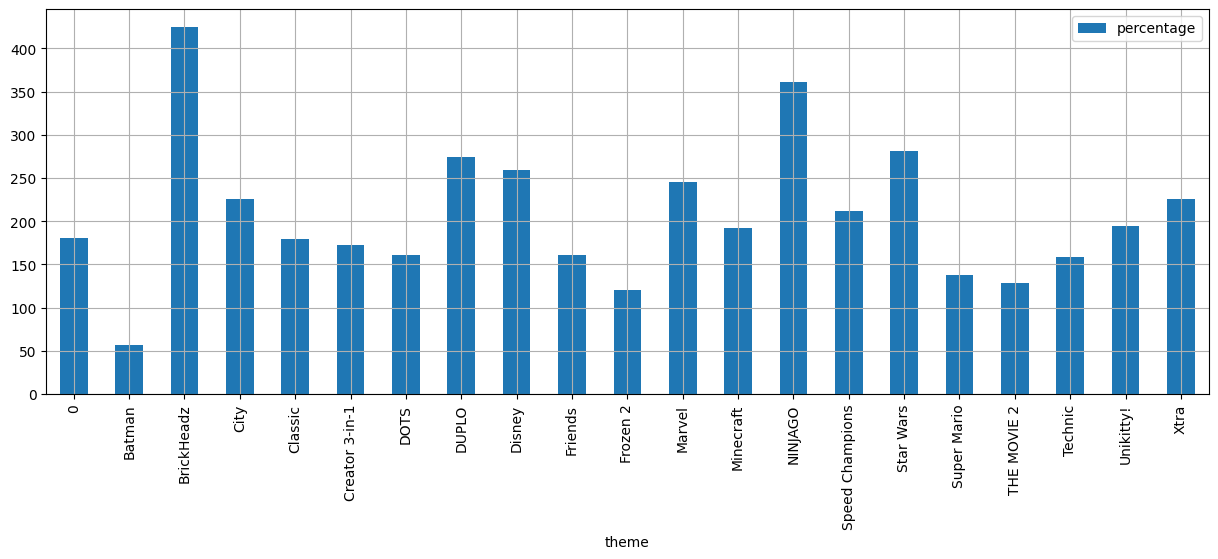

In [10]:
df_icrease_by_theme = df_amazon_update.drop (['set_name', 'price', 'amazon_price', 'year'], axis=1
                                         ).groupby(['theme']).mean()
df_icrease_by_theme.plot (
    y=['percentage'],
    kind = 'bar',
    figsize=(15, 5),
    grid=True    
);